# Import

In [1]:
#local modules
import wrangle as wr
import explore as ex
import model as mo

#standard
import pandas as pd
import numpy as np
import re

#scraping
import requests
from requests import get
from bs4 import BeautifulSoup

#file
import os
import json
from google.oauth2 import service_account
import pandas_gbq

#vizz
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#split and model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#set random state
random_state=123

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

imports loaded successfully, awaiting commands...


In [2]:
# pd.set_option('display.max_colwidth', None)

In [3]:
# df = w.check_file_exists_gbq('cfpb.csv', 'service_key.json')

In [4]:
# df_clean = w.clean_data(df)

In [5]:
# df_clean.to_parquet('df_clean.parquet')

In [6]:
# df_clean = pd.read_parquet('cfpb_prep.parquet')

In [7]:
# df_clean.head()

In [8]:
# df_prep = w.prep_narrative(df_clean)

In [9]:
# df_prep.to_parquet('df_prep.parquet')

In [10]:
# train, validate, test = w.split_data(df_prep,"company_response_to_consumer")

# Prepared DF: (1246736, 10)
# Train: (748041, 10)
# Validate: (249347, 10)
# Test: (249348, 10)

In [11]:
# train.to_parquet('train.parquet')
# validate.to_parquet('validate.parquet')
# test.to_parquet('test.parquet')

In [12]:
# Print the summary statistics of the DataFrame
# train.describe()

In [13]:
# Count the number of non-NA values
# print(train.count())

In [14]:
# train.info()

In [15]:
# train = pd.read_parquet('train.parquet')
# validate = pd.read_parquet('validate.parquet')
# test = pd.read_parquet('test.parquet')

In [16]:
df = wr.wrangle_complaints()

parquet file found and loaded


In [18]:
df = wr.prep_response(df)

In [19]:
# Split
train, validate, test = wr.split_data(df,"response")

Prepared DF: (1238536, 7)
Train: (743121, 7)
Validate: (247707, 7)
Test: (247708, 7)


In [20]:
train

,date_received,company_name,state,tags,product_bins,lemon,response
260446,2022-08-17,Experian Information Solutions Inc.,IL,Average Person,credit_report,hi without influence third party low unfair cr...,relief
148123,2016-07-01,CAPITAL ONE FINANCIAL CORPORATION,PA,Older American,credit_card,feel capital one credit card division last day...,no_relief
430657,2020-11-30,"EQUIFAX, INC.",NY,Servicemember,credit_report,hello identity stolen fraud credit report iden...,no_relief
458,2023-01-25,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,Average Person,credit_report,request block consumer report victim identity ...,relief
294364,2015-09-13,"Convergent Resources, Inc.",NY,Average Person,debt_collection,complaint convergent illegally collection cred...,no_relief
...,...,...,...,...,...,...,...
74588,2020-11-20,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,Average Person,credit_report,applied account closed closed unaware account ...,no_relief
54865,2022-09-20,"Maximus Education, LLC dba Aidvantage",WI,Average Person,credit_report,child support belong credit ran without consent,no_relief
528968,2022-05-17,"CITIBANK, N.A.",NY,Average Person,bank,made transfer account later receive text messa...,no_relief
923416,2020-03-16,LOBEL FINANCIAL CORPORATION,CA,Average Person,debt_collection,missing one payment phone negotiate payment re...,no_relief


## Do specific words tend to receive specific responses? For example, do words related to fraud tend to receive more "closed with relief" responses compared to other issues?

## "Is there a relationship between consumer complaint words and company response?"

Initial Thoughts:
* Separation each word by row and then will be doing a count of how many times the word appears in the lemon column.
* Use a small sample in this case we will only use a max_features of 20,000
* Count Words: Use a tool like CountVectorizer in Python to count how often each word appears in the complaints.
* Compare: Calculate the average count of each word for each type of company response to see which words are used most often.
* Visualize: Create a barplot visual to show which words are most associated with each type of company response.
* Use your word counts to predict the company response using machine learning techniques.

In [52]:
def get_word_counts(train):
    """
    Question 1 - Lugo 
    Calculates the word counts for each response type in the given training data.

    Parameters:
        train (DataFrame): The training data containing the 'lemon' and 'company_response_to_consumer' columns.

    Returns:
        word_counts (DataFrame): A DataFrame that shows the frequency of each word for each response type.
        df_with_words (DataFrame): The original DataFrame merged with the word DataFrame.
        word_counts_ones (DataFrame): A filtered version of word_counts, excluding columns with all zero values.
    """
    train_lemon = train['lemon']
    
    # Initialize a CountVectorizer (or TfidfVectorizer)
    vectorizer = CountVectorizer(max_features=20000,lowercase=False)

    # Fit the vectorizer to the 'lemon' column and transform the column into a matrix
    word_matrix = vectorizer.fit_transform(train_lemon.astype(str))

    # Convert the sparse matrix to a DataFrame
    words_df = pd.DataFrame.sparse.from_spmatrix(word_matrix, columns=vectorizer.get_feature_names_out())

    # merge the word DataFrame with the 'company_response_to_consumer' column
    df_with_words = words_df.merge(train['response'], left_index=True, right_index=True)

    # For each response type, count the frequency of each word
    word_counts = df_with_words.groupby('response_y').sum()

    # Filter out columns (axis=1) where all values are zero
    word_counts_ones = word_counts.loc[:, word_counts.any(axis=0)]
    
    return word_counts, df_with_words, word_counts_ones

In [44]:
# def get_word_counts(train):
"""
Question 1 - Lugo 
Calculates the word counts for each response type in the given training data.

Parameters:
    train (DataFrame): The training data containing the 'lemon' and 'company_response_to_consumer' columns.

Returns:
    word_counts (DataFrame): A DataFrame that shows the frequency of each word for each response type.
    df_with_words (DataFrame): The original DataFrame merged with the word DataFrame.
    word_counts_ones (DataFrame): A filtered version of word_counts, excluding columns with all zero values.
"""
train_lemon = train['lemon']

# Initialize a CountVectorizer (or TfidfVectorizer)
vectorizer = CountVectorizer(max_features=20000,lowercase=False)

# Fit the vectorizer to the 'lemon' column and transform the column into a matrix
word_matrix = vectorizer.fit_transform(train_lemon.astype(str))

# Convert the sparse matrix to a DataFrame
words_df = pd.DataFrame.sparse.from_spmatrix(word_matrix, columns=vectorizer.get_feature_names_out())

# merge the word DataFrame with the 'company_response_to_consumer' column
df_with_words = words_df.merge(train['response'], left_index=True, right_index=True)

# For each response type, count the frequency of each word
word_counts = df_with_words.groupby('response_y').sum()

# Filter out columns (axis=1) where all values are zero
word_counts_ones = word_counts.loc[:, word_counts.any(axis=0)]

# return word_counts, df_with_words, word_counts_ones

In [46]:
def top_15_words(word_counts_ones):
    """
    continuation of Q1
    Retrieves the top 15 most frequently occurring words for each response type from the given word counts DataFrame.

    Parameters:
        word_counts_ones (DataFrame): The word counts DataFrame, filtered to exclude columns with all zero values.

    Returns:
        top_words_df (DataFrame): A DataFrame containing the top 15 words for each response type, indexed by the response types.
    """
    # Define the responses
    responses = ['relief', 'no_relief']

    # Initialize an empty DataFrame to store the results
    top_words_df = pd.DataFrame()

    # Loop over the responses
    for response in responses:
        # Get the 10 words that appear most frequently in narratives associated with the current response
        top_words = word_counts_ones.loc[response].nlargest(15)

        # Convert the Series to a DataFrame and transpose it
        top_words_df_temp = pd.DataFrame(top_words).transpose()

        # Append the temporary DataFrame to the main DataFrame
        top_words_df = pd.concat([top_words_df, top_words_df_temp])

    # Set the index of the DataFrame to the responses
    top_words_df.index = responses
    return top_words_df

In [63]:
def frequent_words_plot(df_with_words,word_counts_ones):
    """
    Continuation of Q1
    Creates a bar plot to visualize the top 10 most frequently occurring words for each response type.

    Parameters:
        df_with_words (DataFrame): The DataFrame merged with the word DataFrame.
        word_counts_ones (DataFrame): The filtered word counts DataFrame.

    Returns:
        None (displays the plot)
    """
    # Get the unique response types
    response_types = df_with_words['response_y'].unique()

    # For each response type
    for response in response_types:
        # Get the top 10 words
        top_words = word_counts_ones.loc[response].nlargest(10)

        # Create a bar plot
        plt.figure(figsize=(10, 5))
        plt.bar(top_words.index, top_words.values)
        plt.title(f'Top 10 words for "{response}" response')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
    return plt.show()

In [53]:
word_counts, df_with_words,word_counts_ones = get_word_counts(train)

In [54]:
word_counts

,aa,aal,aam,aba,aback,abandon,abandoned,abandonment,abate,abatement,...,zirconium,zloty,zo,zodiac,zombie,zone,zoned,zoning,zoo,zoom
response_y,,,,,,,,,,,,,,,,,,,,,
no_relief,189,1,0,35,36,53,300,52,3,33,...,1,0,0,0,90,346,6,21,2,18
relief,59,0,0,11,15,20,83,17,4,6,...,0,0,1,1,26,94,3,3,0,4


In [55]:
df_with_words

,aa,aal,aam,aba,aback,abandon,abandoned,abandonment,abate,abatement,...,zloty,zo,zodiac,zombie,zone,zoned,zoning,zoo,zoom,response_y
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,relief
743114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief
743116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief
743119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no_relief


In [56]:
word_counts_ones

,aa,aal,aba,aback,abandon,abandoned,abandonment,abate,abatement,abb,...,zirconia,zirconium,zo,zodiac,zombie,zone,zoned,zoning,zoo,zoom
response_y,,,,,,,,,,,,,,,,,,,,,
no_relief,189,1,35,36,53,300,52,3,33,2,...,1,1,0,0,90,346,6,21,2,18
relief,59,0,11,15,20,83,17,4,6,0,...,0,0,1,1,26,94,3,3,0,4


In [57]:
word_counts_ones.columns

Index(['aa', 'aal', 'aba', 'aback', 'abandon', 'abandoned', 'abandonment',
       'abate', 'abatement', 'abb',
       ...
       'zirconia', 'zirconium', 'zo', 'zodiac', 'zombie', 'zone', 'zoned',
       'zoning', 'zoo', 'zoom'],
      dtype='object', length=19222)

In [60]:
top = top_15_words(word_counts_ones)

In [61]:
top.T

,relief,no_relief
credit,180291,609695
account,145662,498824
report,89481,303148
information,86386,292674
consumer,52752,175595
payment,51507,177663
time,51143,172501
would,49463,167623
debt,46615,157406
day,45479,156484


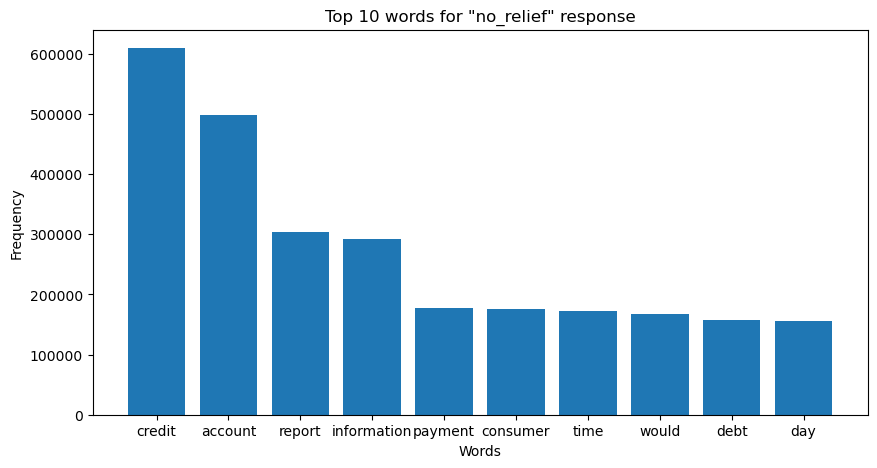

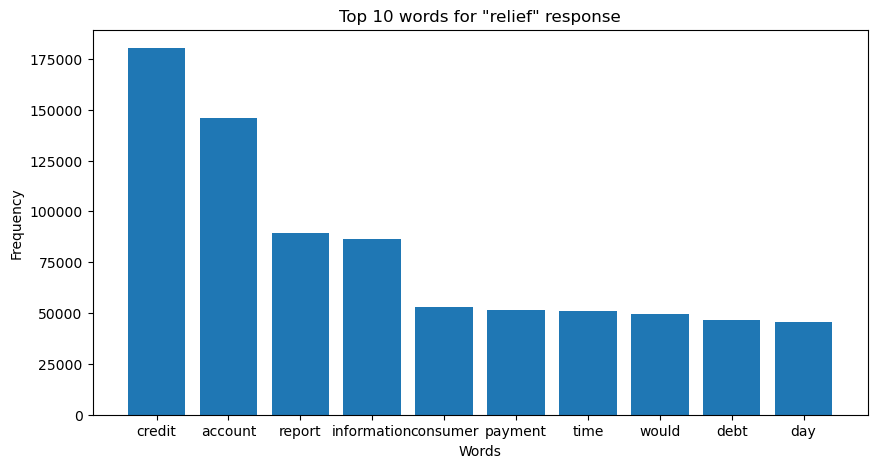

In [65]:
frequent_words_plot(df_with_words,word_counts_ones)

In [64]:
frequenct_words_plot(df_with_words,word_counts_ones)

NameError: name 'frequenct_words_plot' is not defined

In [ ]:
# Get the unique response types
response_types = df_with_words['response_y'].unique()

# Initialize an empty dictionary to store the unique words for each response type
unique_words = {}

# For each response type
for response in response_types:
    # Get the words associated with this response type
    words = word_counts_ones.loc[response]
    
    # Get the words that are unique to this response type
    unique = words[~words.index.isin(np.concatenate([word_counts_ones.loc[other].index for other in response_types if other != response]))]
    
    # Add the unique words to the dictionary
    unique_words[response] = unique.index.tolist()

# Print the unique words for each response type
for response, words in unique_words.items():
    print(f'Unique words for "{response}" response:')
    print(words)
    print('\n')


In [ ]:
# Initialize an empty dictionary to store the unique words for each response type
unique_words = {}

# For each response type
for response in response_types:
    # Get the words associated with this response type
    words = word_counts_ones.loc[response]
    
    # Calculate the difference in frequency between this response type and the others
    diff = words - word_counts_ones.loc[[other for other in response_types if other != response]].mean()
    
    # Convert the sparse Series to a dense one
    diff_dense = diff.sparse.to_dense()
    
    # Get the top 10 words with the highest difference in frequency
    unique = diff_dense.nlargest(10)
    
    # Add the unique words to the dictionary
    unique_words[response] = unique.index.tolist()

# Print the unique words for each response type
for response, words in unique_words.items():
    print(f'Unique words for "{response}" response:')
    print(words)
    print('\n')


In [ ]:
import pandas as pd

def create_dataframe():
    """
    This function creates a DataFrame that contains information about the columns of a dataset.
    The DataFrame includes the column name, the percentage of null values in the column, the number of unique values in the column, and the decision made about how to handle the column for further analysis.

    Returns:
        df (DataFrame): A pandas DataFrame that contains the column information.
    """

    # Create a dictionary with your data
    data = {
        "Column Name": ["product", "subproduct", "issue", "subissue", "consumer_complaint_narrative", "company_public_response", "zip code", "consumer_consent_provided", "submitted_via", "date_sent_to_company", "timely_response", "consumer_disputed", "complaint_id"],
        "Null Values": ["0%", "7%", "0%", "20%", "64%", "56%", "1%", "25%", "0%", "0%", "0%", "77%", "0%"],
        "Unique Values": ["-", "-", "165", "221", "-", "-", "-", "-", "-", "-", "-", "-", "-"],
        "Decision": ["Engineered Feature: Bin related products/services together then drop", "Drop", "Future Iteration", "Drop", "Renamed to narrative, drop all null values, drop after NLTK cleaning", "Keep for analysis", "Future Iteration", "Drop", "Drop", "Future Iteration", "Future Iteration", "Future Iteration", "Drop"]
    }

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)

    # Reset the index and drop the index column
    df.reset_index(drop=True, inplace=True)

    return df



In [ ]:
df = create_dataframe()
print(df)


In [ ]:
df

In [ ]:
[{'Column Name': 'product', 'Null Values': '0%', 'Unique Values': '-', 'Decision': 'Engineered Feature: Bin related products/services together then drop'},
 {'Column Name': 'subproduct', 'Null Values': '7%', 'Unique Values': '-', 'Decision': 'Drop'},
 {'Column Name': 'issue', 'Null Values': '0%', 'Unique Values': '165', 'Decision': 'Future Iteration'},
 ...
]


| Column Name                  | Null Values   | Unique Values   | Decision                                                                 |
|:-----------------------------|:--------------|:----------------|:-------------------------------------------------------------------------|
| product                      | 0%            | -               | Engineered Feature: Bin related products/services together then drop     |
| subproduct                   | 7%            | -               | Drop                                                                    |
| issue                        | 0%            | 165             | Future Iteration                                                        |
| ...                          | ...           | ...             | ...                                                                     |


## Data Dictionary

| Column Name | Null Values | Unique Values | Decision |
|-------------|-------------|---------------|----------|
| product | 0% | - | Engineered Feature: Bin related products/services together then drop |
| subproduct | 7% | - | Drop |
| issue | 0% | 165 | Future Iteration |
| subissue | 20% | 221 | Drop |
| consumer_complaint_narrative | 64% | - | Renamed to narrative, drop all null values, drop after NLTK cleaning |
| company_public_response | 56% | - | Keep for analysis |
| zip code | 1% | - | Future Iteration |
| consumer_consent_provided | 25% | - | Drop |
| submitted_via | 0% | - | Drop |
| date_sent_to_company | 0% | - | Future Iteration |
| timely_response | 0% | - | Future Iteration |
| consumer_disputed | 77% | - | Future Iteration |
| complaint_id | 0% | - | Drop |


In [ ]:
img = WordCloud(background_color='white').generate(' '.join(business))

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title("Most Common business Words")
plt.show()